# **Multifractal Analysis Using `pymultifracs`**
### *Applying Wavelet-Based MFA to Time Series*



## **📌 Introduction**
Multifractal analysis (MFA) extends classical fractal analysis by allowing for multiple scaling exponents within a system. It is widely used in neuroscience and physics to study **scale-free dynamics** in complex signals.

This notebook follows a **step-by-step workflow** to apply MFA on a simulated **Multifractal Random Walk (MRW)** using the `pymultifracs` package. The pipeline mirrors Merlin's methodology, breaking it down into clear stages.

## **🎯 Goal of This Notebook**
- Simulate a **Multifractal Random Walk (MRW)**.
- Compute **wavelet transforms** to extract multi-scale properties.
- Compute **wavelet leaders** and assess signal regularity.
- Perform **multifractal regression analysis**.
- Interpret the results.




In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pymultifracs.simul import mrw
from pymultifracs import wavelet_analysis
from pymultifracs import mfa
from pymultifracs.utils import build_q_log

---
## **🔹 Step 1: Simulating a Multifractal Random Walk (MRW)**
To illustrate MFA, we first generate a synthetic MRW, which is a stochastic process exhibiting **multifractal scaling properties**.

📌 **Goal:** Generate synthetic multifractal signals to analyze.  
📌 **Why?** This allows us to test the multifractal analysis (MFA) methods on controlled data.  
📌 **Key output:** A 2D array of time series (shape: *(N_samples, N_realizations)*).  


In [26]:
nb_generated_series = 1
X = mrw(shape=(2**15, nb_generated_series), H=0.8, lam=np.sqrt(.05), L=2**15)



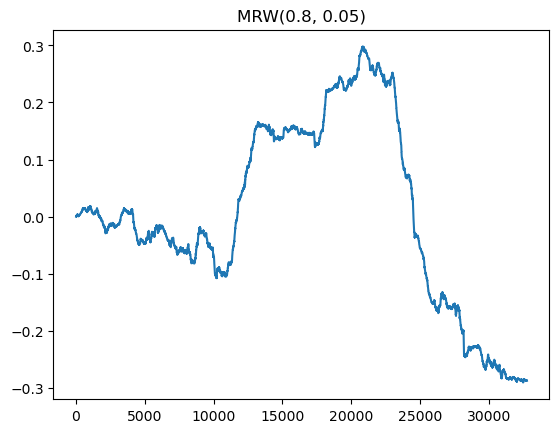

In [27]:
plt.plot(X)
plt.title('MRW(0.8, 0.05)')
plt.show()

In [25]:
X.shape

(32768, 1)

✔️ **Interpretation:**  
- The simulated MRW has **long-range dependencies**, meaning fluctuations persist over time.  
- The **Hurst exponent (H=0.8)** controls smoothness:  
  - **H ≈ 0.5** → No correlation (random walk).  
  - **H > 0.5** → Persistent trend (long-memory).  
  - **H < 0.5** → Anti-persistent (mean-reverting).  

---
## **🔹 Step 2: Compute the Wavelet Transform**
To analyze the **scale-dependent properties** of our signal, we perform a **wavelet transform**. This step decomposes the signal into different scales, revealing local fluctuations.

📌 **Goal:** Decompose the signal into multiple temporal scales (j).  
📌 **Why?** Wavelet analysis reveals how different scales contribute to the overall signal.  
📌 **Key output:** A `.WaveletDec` object containing wavelet coefficients at different scales.  
📌 **Key Parameters:**
- `wt_name='db3'` → Use Daubechies wavelet with 3 vanishing moments.
- `j2=None` → Analyze up to the coarsest scale possible.
- `normalization=1` → Standard **L1 normalization** is applied to ensure scale invariance.

- At **small scales (j low)** → More variation, capturing fast fluctuations.  
- At **large scales (j high)** → More stable, capturing global trends.  


In [24]:
WT = wavelet_analysis(X, wt_name='db3', j2=None, normalization=1)

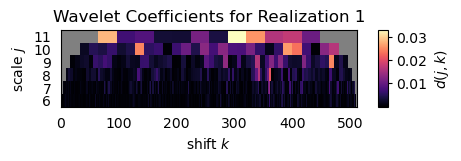

In [23]:
for i in range(nb_generated_series):
    WT_realization = wavelet_analysis(X[:, i], wt_name='db3')  # i-th time series
    WT_realization.plot(j1=6, j2=11)
    plt.title(f"Wavelet Coefficients for Realization {i+1}")
    plt.show()


✔️ **Interpretation:**  
- **X-axis (k)** → Time shifts across the signal.  
- **Y-axis (j)** → Different scales (small j = fine details, large j = coarse details).  
- **Color intensity (d(j, k))** → Magnitude of wavelet coefficients (higher = stronger local variations).  
- Some areas of the plot have **clusters of bright values** (strong variations), while others remain dark.
- This suggests that the signal has **localized bursts of activity**, which is a key characteristic of **multifractal signals**.


---

## **🔹 Step 3: Extracting Multi-Resolution Quantities**

After computing the wavelet transform, we extract key **multi-resolution quantities** that will help us analyze the scaling behavior of our signal.

These quantities provide different ways to measure singularities and regularity in the signal.

📌 **Goal:** Compute the wavelet-based descriptors required for multifractal analysis.  
📌 **Why?** These descriptors allow us to estimate scaling behaviors at different scales.  
📌 **Key output:**  
- **Wavelet leaders (`WTL`)** → Captures local singularities.  
- **Wavelet p-leaders (`WTpL`)** → Generalized form using exponent `p`.  
- **Wavelet structure elements (`WSE`)** → Used to study temporal evolution of singularities.  

In [6]:
# Compute standard Wavelet Leaders (captures local singularities)
WTL = WT.get_leaders(p_exp=np.inf)

# Compute Wavelet p-Leaders (generalization using L2-norm)
WTpL = WT.get_leaders(p_exp=2)

# Compute Wavelet Structure Elements (WSE) to analyze scale invariance
WSE = WT.get_wse(theta=0.5)

print("Multi-resolution quantities computed successfully!")


Multi-resolution quantities computed successfully!


### 🔍 Checking the Number of Coefficients per Scale for each realization


In [7]:
def count_wavelet_coeffs_all_realizations(wavelet_obj, name):
    print(f"\n📌 {name} - Number of Coefficients per Scale for Each Realization:")
    for j, values in wavelet_obj.values.items():
        n_realizations = values.shape[1] if values.ndim > 1 else 1  # Check if multiple realizations exist
        print(f"Scale {j}: {values.shape[0]} coefficients per realization ({n_realizations} realizations)")

# Call the function for each wavelet object
count_wavelet_coeffs_all_realizations(WTL, "Wavelet Leaders (WTL)")
count_wavelet_coeffs_all_realizations(WTpL, "Wavelet p-Leaders (WTpL)")
count_wavelet_coeffs_all_realizations(WSE, "Wavelet Structure Elements (WSE)")



📌 Wavelet Leaders (WTL) - Number of Coefficients per Scale for Each Realization:
Scale 1: 16385 coefficients per realization (1 realizations)
Scale 2: 8192 coefficients per realization (1 realizations)
Scale 3: 4096 coefficients per realization (1 realizations)
Scale 4: 2048 coefficients per realization (1 realizations)
Scale 5: 1024 coefficients per realization (1 realizations)
Scale 6: 512 coefficients per realization (1 realizations)
Scale 7: 256 coefficients per realization (1 realizations)
Scale 8: 128 coefficients per realization (1 realizations)
Scale 9: 64 coefficients per realization (1 realizations)
Scale 10: 32 coefficients per realization (1 realizations)
Scale 11: 16 coefficients per realization (1 realizations)
Scale 12: 8 coefficients per realization (1 realizations)

📌 Wavelet p-Leaders (WTpL) - Number of Coefficients per Scale for Each Realization:
Scale 1: 16385 coefficients per realization (1 realizations)
Scale 2: 8192 coefficients per realization (1 realizations)


✔️ **Interpretation:**  
- At **small scales (low j)** → More coefficients (high resolution).  
- At **large scales (high j)** → Fewer coefficients (coarse resolution).  
- This pattern follows the wavelet decomposition process where coarser details are represented with fewer coefficients.


---
## **🔹 Step 4: Checking Regularity Conditions**

The `check_regularity` function verifies whether our **Multi-Resolution Quantities (MRQs)** have **sufficient smoothness** for **multifractal analysis (MFA)**. It computes the **minimum Hölder exponent (`h_min`)**, which quantifies the **local regularity** of the signal.


📌 **Goal:** Ensure that the wavelet-based quantities satisfy the minimal regularity conditions.  
📌 **Why?** If the signal is too irregular, its multifractal analysis may be unreliable.  
📌 **How is `h_min` Computed?**  
- `h_min` is obtained by performing **linear regression** on the wavelet-based structure functions over the selected **scaling range (j1, j2)**.
- It represents the lowest regularity detected in the signal.
- The result is a **2D NumPy array** of shape **(N_scaling_ranges, N_realizations)**:
  - Rows → Different scaling ranges tested.
  - Columns → Different time series (realizations).

📌 **Key Validations:**  
⚠️ If `h_min.min() ≤ 0`: Some parts of the signal may require **fractional integration** to improve smoothness.  
🚨 If `h_min.max() ≤ 0`: The signal is **too irregular** and cannot be analyzed.


In [8]:
# Define the scaling ranges for analysis
scaling_ranges = [(2, 8), (3, 8)]

In [9]:
# Check the regularity of different multi-resolution quantities
WT.check_regularity(scaling_ranges)
WTL.check_regularity(scaling_ranges)
WTpL.check_regularity(scaling_ranges)
WSE.check_regularity(scaling_ranges)

print("Regularity check completed!")


Regularity check completed!


In [10]:
# Example at scale j=6, 512 coefficients for each time series (5 in total)
print(WTL.values[6].shape) 

(512, 1)


In [11]:
print("WTL Regularity:", WTL.check_regularity(scaling_ranges))
print("WTpL Regularity:", WTpL.check_regularity(scaling_ranges))
print("WSE Regularity:", WSE.check_regularity(scaling_ranges))


WTL Regularity: [[0.7532704 ]
 [0.79185466]]
WTpL Regularity: [[1.64826287]
 [1.66560531]]
WSE Regularity: None


✔️ **Interpretation:**  
- `h_min` summarizes the **smoothness** of the signal over the selected range.
- For our eample with 2 scaling ranges and 1 time series: h_min is derived from each **entire scaling range (j1 → j2)** for the time serie.
- The signal passes the regularity test if all `h_min > 0`, meaning MFA can proceed without modifications.
- We can observe that the signal has enough regularity for MFA because h_min > 0 in both WTL and WTpL.
- We can observe that p-Leaders (WTpL) capture more regularity than wavelet leaders (WTL) -> Higher h-min.
- Fractional integration is not necessary, since there are no negative h_min values.
- If h_min were negative, you’d need to apply WT.auto_integrate(scaling_ranges).


---
## **🔹 Step 5: Fractional Integration**

📌 **Goal:** Modify the wavelet-based descriptors to enforce minimal regularity conditions.  
📌 **Why?** This step ensures that all signals meet the requirements for valid multifractal scaling.  
📌 **Key output:** A transformed dataset with appropriate smoothness. 

In [12]:
# Automatic Integration (Letting the algorithm decide the best value)
WTpL = WTpL.auto_integrate(scaling_ranges)

# Manual fractional integration applied with γ = 0.5
WT_int = WT.integrate(0.5)

print("Automatic fractional integration applied!")

Automatic fractional integration applied!


✔️ **Interpretation:**  
- **Auto-integration** finds an optimal integration parameter automatically.  
- **Manual integration** allows us to set a predefined fractional order.  
- This step **normalizes the signal smoothness**, preventing spurious multifractal estimates.  


---
## **🔹 Step 6: Performing Multifractal Analysis (MFA)**  

📌 **Goal:** Extract multifractal parameters (`c1`, `c2`) by analyzing the scaling behavior of wavelet leaders.  
📌 **Why?** These parameters describe the **scaling properties** of the signal and help distinguish between monofractal and multifractal behavior.  
📌 **Key output:**  
- **Structure functions (`ζ(q)`)** → Capture power-law scaling across scales.  
- **Cumulants (`c1`, `c2`)** → Quantify the strength of multifractality.  
- **Multifractal spectrum (`D(h)`)** → Characterizes the distribution of singularities.  

In [13]:
# Perform multifractal analysis on the p-leaders
pwt = mfa(WTpL, scaling_ranges, weighted='Nj', q=[-2, -1, 1, 2])



### **1️. Structure Functions (`S_q(j)`)**  

📌 **What is `S_q(j)`?**  
It represents the **q-th moment of the wavelet leaders** at each scale `j` and summarizes the statistical properties of fluctuations at that scale:

 $$
S_q(j) = \frac{1}{N_j} \sum_k |L(j,k)|^q
 $$

where:  
- **`L(j, k)`** → Wavelet leaders at scale `j` and position `k`.  
- **`N_j`** → Number of available wavelet leaders at scale `j`.  
- **`q`** → Moment controlling how fluctuations are emphasized:
  - **q < 0** → Highlights small fluctuations (weak singularities).  
  - If $q=1$, we take the mean of wavelet leaders at scale $j$ (like averaging absolute values) / If $q=2$, we take the variance-like measure.

📌 **Why is `S_q(j)` important?**  
- It follows a **power-law scaling** over scales:

 $$
S_q(j) \propto 2^{\zeta(q) j}
 $$

- The exponent **`ζ(q)`** determines how fluctuations evolve across scales.  
- A **linear `ζ(q)`** suggests **monofractal** behavior, while a **nonlinear `ζ(q)`** indicates **multifractality**.
- When we take the **logarithm** of both sides reveals a **linear trend** between `log(S_q(j))` and `j`:


 $$
\log S_q(j) = \zeta(q) j + C
 $$

- The **slope of this regression gives `ζ(q)`**, which describes the **scaling properties** of the signal.

In [14]:
# Extract structure function values (S_q(j)) for the first realization and first scaling range
structure_values = pwt.structure.values[:, :, 0, 0] 

# Define q-values and scales
q_values = pwt.structure.q
scales = np.arange(1, structure_values.shape[1] + 1)  # Scale indices

# Create DataFrame for Structure Function**
structure_function_df = pd.DataFrame(
    structure_values.T,  # Transpose so scales are rows and q-values are columns
    index=[f"Scale {j}" for j in scales], 
    columns=[f"q={q}" for q in q_values]
)

print("\n✅ Structure Function Values:")
display(structure_function_df)


✅ Structure Function Values:


,q=-2,q=-1,q=1,q=2
Scale 1,29.384355,14.062878,-13.135280,-25.502351
Scale 2,26.977349,13.091259,-12.382389,-24.108926
Scale 3,25.224235,12.240344,-11.581498,-22.584803
Scale 4,23.346657,11.380385,-10.796545,-21.074037
Scale 5,21.603278,10.509559,-9.923182,-19.322420
Scale 6,19.887150,9.685774,-9.131284,-17.747155
Scale 7,18.109783,8.803794,-8.274842,-16.000655
Scale 8,16.335098,7.949097,-7.457248,-14.363957
Scale 9,14.549882,7.065858,-6.630890,-12.875992
Scale 10,12.234714,6.005678,-5.787013,-11.388163


✔️ **Interpretation:**  
- The structure function values represent the multifractal scaling behavior of the p-leaders.
- **4 q-values** → Corresponding to `q = [-2, -1, 1, 2]`  
- **12 scales \( j \)** → From \( j=1 \) to \( j=12 \)  

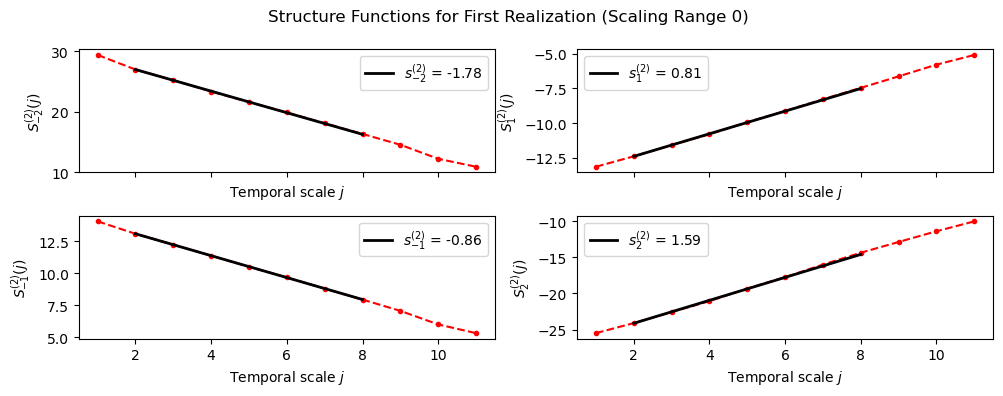

In [15]:
# Plot the structure functions for the first realization, first scaling range
pwt.structure.plot(figsize=(10, 4), nrow=2, scaling_range=0)  # Scaling range 0
plt.suptitle("Structure Functions for First Realization (Scaling Range 0)")
plt.show()


✔️ **Interpretation:**  
- **Negative slopes** (Top-left, Bottom-left) indicate **decreasing fluctuations** across scales → Large fluctuations at small scales smooth out at larger scales.  
- **Positive slopes** (Top-right, Bottom-right) suggest **increasing fluctuations** at larger scales → The variability grows as we observe coarser scales.  
- The **variation in slopes across different $ q $ values** confirms **multifractality** → Different scaling exponents for different moments $ q $ imply a non-uniform scaling behavior.  
- **Linear relationships in log-log space** indicate **scaling behavior** → The presence of power-law scaling suggests self-similarity across scales.  
- **To determine if the process is mono- or multifractal**, we analyze the behavior of the **scaling function** $ \zeta(q) $:
  - If $ \zeta(q) $ is **linear in $ q $**, the signal is **monofractal** (same scaling properties across the entire signal).  
  - If $ \zeta(q) $ is **nonlinear in $ q $**, the signal is **multifractal** (different regions exhibit different scaling behaviors).  
- These charts represent results from **one realization**, **one scaling range$$ of the signal.


---

### **2️. The Scaling Function `ζ(q)` and the Log-Cumulants (`c1`, `c2`)**  

📌 **The scaling function `ζ(q)`**  
The scaling function `ζ(q)` characterizes how different moments of the wavelet leaders evolve with scale.  
It is often expanded as:

 $$
\zeta(q) = c_1 q + \frac{c_2}{2} q^2 + \dots
 $$

where:  
- **`c1` (first log-cumulant)** → Measures **global regularity** (self-similarity).  
- **`c2` (second log-cumulant)** → Measures **multifractality strength** (spread of singularities).  

📌 **Why are `c1` and `c2` important?**  
- If **`c2 ≈ 0`**, the process is **monofractal** (same scaling everywhere).  
- If **`c2 ≠ 0`**, the process is **multifractal**, meaning different parts of the signal have different scaling behaviors.
- **Large `c2`** → Strong multifractality (irregular, highly non-uniform fluctuations).  
- **Small `c2`** → Weak multifractality (more uniform scaling behavior).  



In [16]:
# Extract Scaling Function ζ(q) at a middle scale instead of the last one**
mid_scale_index = structure_values.shape[1] // 2  # Choose a midpoint scale

# Extract scaling values at the mid-scale
scaling_values = pwt.structure.values[:, mid_scale_index, :, 0]  # (N_q, N_scaling_ranges)

# Create DataFrame for Scaling Function**
scaling_function_df = pd.DataFrame(
    scaling_values.T,  # Transpose so scaling ranges are rows and q-values are columns
    index=[f"Scaling Range {i+1}" for i in range(scaling_values.shape[1])],  
    columns=[f"q={q}" for q in q_values]
)

print("\n✅ Scaling Function Values (Fixed):")
display(scaling_function_df)



✅ Scaling Function Values (Fixed):


,q=-2,q=-1,q=1,q=2
Scaling Range 1,18.109783,8.803794,-8.274842,-16.000655
Scaling Range 2,18.101769,8.799787,-8.270835,-15.992640


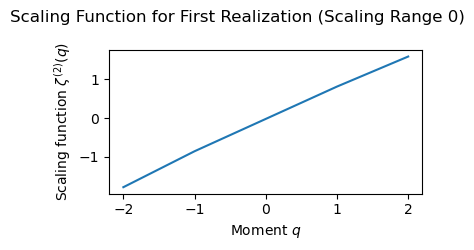

In [17]:
# Plot the scaling function ζ(q) for the first realization, first scaling range
pwt.structure.plot_scaling(range_idx=0)
plt.suptitle("Scaling Function for First Realization (Scaling Range 0)")
plt.show()

✔️ **Interpretation:**  

- The y-axis represents the **scaling function** which describes how the moments of the wavelet leaders scale across different temporal scales.  
- The x-axis represents the **moment** \( q \), which determines how different fluctuations in the signal contribute to the scaling behavior.  
- When the function **$ \zeta(q) $ is nonlinear**, it means the signal exhibits **multifractal behavior**.  
- If the function is linear ($( \zeta(q) = c_1 q $)), the process would be **monofractal**, meaning the same scaling applies everywhere.  
- The curve bends upwards, indicating that fluctuations of different intensities scale differently across time.  
- The curvature of  $ \zeta(q) $ is used to compute **log-cumulants** (\( c_1, c_2 \)), which help quantify **multifractality strength**.  
- We can fit $ \zeta(q) $ with a quadratic function to extract **log-cumulants** \( c_1 \) and \( c_2 \).  



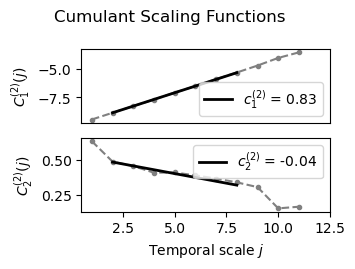

In [18]:
# Plot the cumulant scaling functions for the first realization, for one scaling range
pwt.cumulants.plot(range_idx=0)
plt.suptitle("Cumulant Scaling Functions")
plt.show()

✔️ **Interpretation:**  

- **Top plot**: Shows \( C_1(j) \), the first cumulant across scales \( j \).  
  - The **positive slope** indicates increasing fluctuations with scale.  

- **Bottom plot**: Shows \( C_2(j) \), the second cumulant across scales \( j \).  
  - The **negative slope** confirms **multifractal behavior**.  

- **Dashed gray line**: Raw cumulant values computed at each scale.  
- **Black solid line**: Linear fit over the chosen **scaling range**, used to estimate final \( c_1 \) and \( c_2 \).  

In [19]:
# Extract for the first realization, first scaling range
C1_values = pwt.cumulants.c1[:,0, 0][0]
C2_values = pwt.cumulants.c2[:, 0, 0][1]

print("\n✅ Cumulant Values:")
print("C1 Values:", C1_values)
print("C2 Values:", C2_values)  


✅ Cumulant Values:
C1 Values: 0.8329408702105484
C2 Values: -0.033348970904485076


✔️ **Interpretation:**  
  
- \( C_1 \) represents **the average regularity** (self-similarity).  
- \( C_2 \) quantifies **multifractal strength** (how much the scaling varies across the signal).  
- **Two values for each cumulant** → **One per scaling range** (as many values couple as realizations)
- The process is **multifractal** (\( C_2 \) is negative).  
- The estimated **cumulants \( c_1 \) and \( c_2 \)** summarize its scaling behavior.  




### **3️. Computing the Multifractal Spectrum (`D(h)`)**  

📌 **What is `D(h)`?**  
The **multifractal spectrum** `D(h)` represents the **distribution of singularities** in the signal, where:  
- **`h` (Hölder exponent)** → Measures the **local regularity** of the signal.  
- **`D(h)`** → Describes how frequently different `h` values appear.

📌 **Why is `D(h)` important?**  
- A **broad `D(h)`** → Strong multifractality (wide range of singularities).  
- A **narrow `D(h)`** → Weak multifractality (mostly uniform scaling).  
- The **maximum of `D(h)`** corresponds to the most dominant singularity in the signal.  
- The **width of `D(h)`** reveals how much the scaling properties **vary across the signal**.   


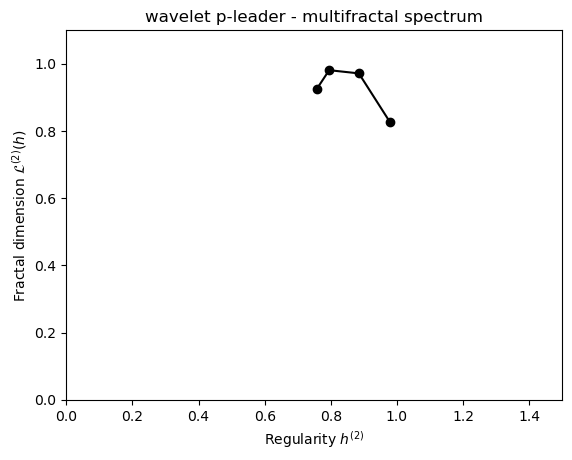

In [20]:
# Plot the multifractal spectrum D(h)
pwt.spectrum.plot()
plt.show()


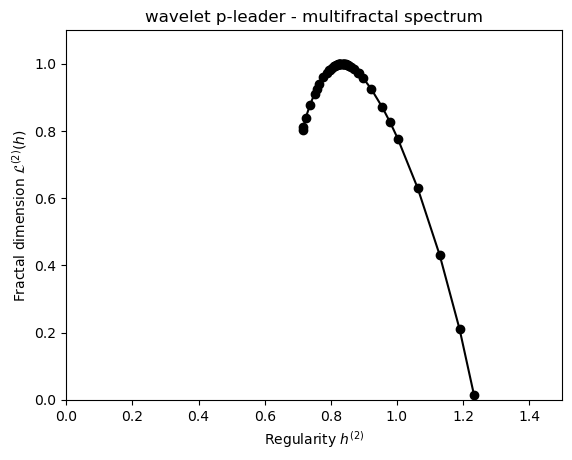

In [ ]:
# Compute multifractal spectrum using a more densely sampled q range (only for testing and for a better gaph interpretation)
pwt = mfa(WTpL, scaling_ranges, weighted='Nj', q=build_q_log(.1, 5, 20))
pwt.spectrum.plot()
plt.show()